# Entry Tier Experiment Lab

Compare baseline vs tiered entry modes with shared exit discipline.

In [1]:
from __future__ import annotations

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

SYMBOL = "MSFT"  # APO, TSLA, MSFT
ROOT = Path.cwd()
if not (ROOT / "out").exists():
    ROOT = ROOT.parent

EXP_DIR = ROOT / "out" / "entry_tier_experiment"
SUMMARY_CSV = EXP_DIR / "summary.csv"
MODES = ["baseline_confirmed", "tiered_candidate_25_early_50", "relaxed_weekly_full"]

summary = pd.read_csv(SUMMARY_CSV)
print("Summary by mode/symbol")
print(summary.to_string(index=False))

print("\nReturn % pivot")
print(summary.pivot(index="Symbol", columns="Mode", values="TotalReturnPct").to_string())

print("\nMax DD % pivot")
print(summary.pivot(index="Symbol", columns="Mode", values="MaxDrawdownPct").to_string())

Summary by mode/symbol
                        Mode Symbol  Rows  TradeExecutions  RoundTrips  WinRatePct  EndingEquity  TotalReturnPct  RealizedPnL  MaxDrawdownPct LatestDate
          baseline_confirmed    APO   782               16           8       50.00     167911.43         67.9114     67911.43         12.3706 2026-02-13
tiered_candidate_25_early_50    APO   782               17           8       50.00     170676.56         70.6766     70676.56         12.3706 2026-02-13
         relaxed_weekly_full    APO   782               16           8       50.00     177884.97         77.8850     77884.96         12.3706 2026-02-13
          baseline_confirmed   TSLA   782               14           7       28.57     136697.27         36.6973     36697.27         21.4457 2026-02-13
tiered_candidate_25_early_50   TSLA   782               27          13       38.46     138130.83         38.1308     38130.83         21.4419 2026-02-13
         relaxed_weekly_full   TSLA   782               26 

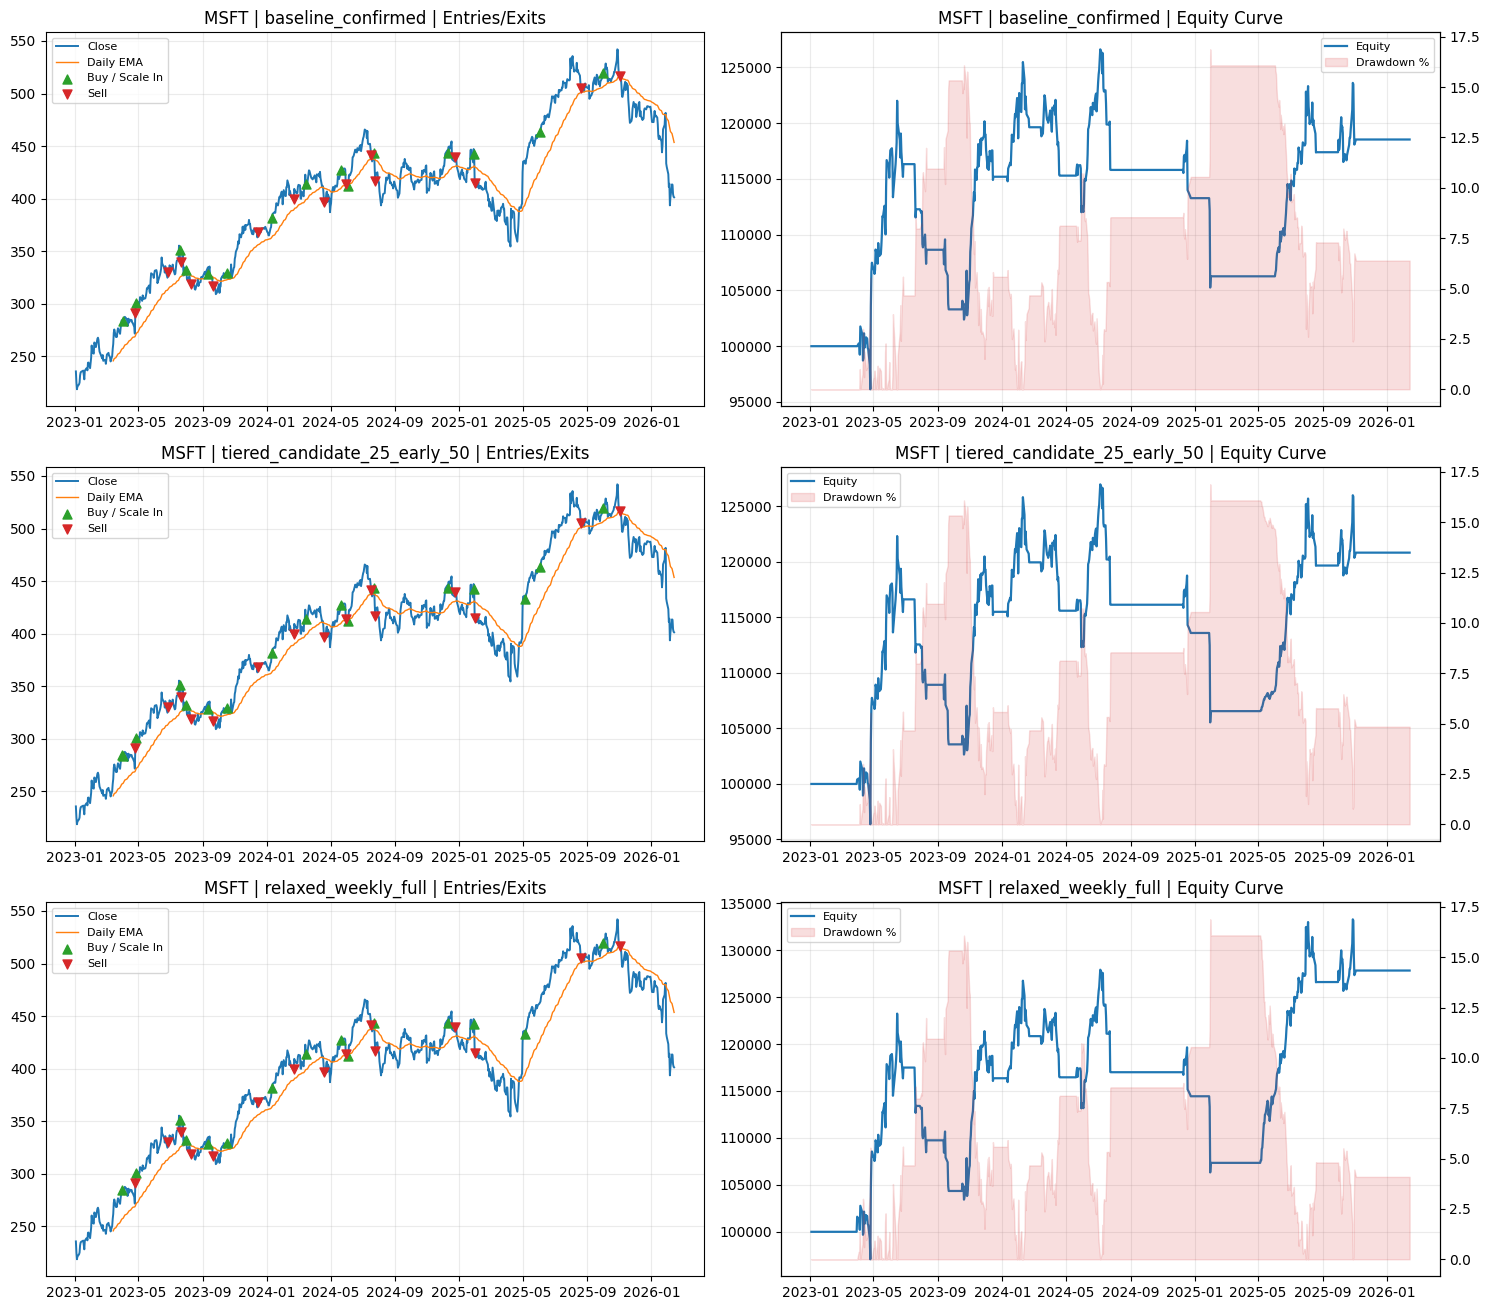

In [2]:
frames = {}
for mode in MODES:
    path = EXP_DIR / mode / f"{SYMBOL}.csv"
    df = pd.read_csv(path, parse_dates=["Date"])
    frames[mode] = df

fig, axes = plt.subplots(len(MODES), 2, figsize=(15, 4.4 * len(MODES)), sharex=False)
if len(MODES) == 1:
    axes = [axes]

for idx, mode in enumerate(MODES):
    df = frames[mode]
    dates = pd.to_datetime(df["Date"])
    ax_p = axes[idx][0]
    ax_e = axes[idx][1]

    ax_p.plot(dates, df["Close"], color="#1f77b4", linewidth=1.4, label="Close")
    ax_p.plot(dates, pd.to_numeric(df["DailyEMA"], errors="coerce"), color="#ff7f0e", linewidth=1.0, label="Daily EMA")

    buys = df[df["ExecutedAction"].isin(["BUY", "SCALE_IN"])]
    sells = df[df["ExecutedAction"] == "SELL"]
    if not buys.empty:
        ax_p.scatter(buys["Date"], buys["Close"], marker="^", s=42, color="#2ca02c", label="Buy / Scale In", zorder=5)
    if not sells.empty:
        ax_p.scatter(sells["Date"], sells["Close"], marker="v", s=42, color="#d62728", label="Sell", zorder=5)

    ax_p.set_title(f"{SYMBOL} | {mode} | Entries/Exits")
    ax_p.grid(alpha=0.25)
    ax_p.legend(loc="best", fontsize=8)

    ax_e.plot(dates, df["Equity"], color="#1f77b4", linewidth=1.6, label="Equity")
    ax_dd = ax_e.twinx()
    ax_dd.fill_between(dates, 0.0, pd.to_numeric(df["DrawdownPct"], errors="coerce"), color="#d62728", alpha=0.15, label="Drawdown %")
    ax_e.set_title(f"{SYMBOL} | {mode} | Equity Curve")
    ax_e.grid(alpha=0.25)
    l1, t1 = ax_e.get_legend_handles_labels()
    l2, t2 = ax_dd.get_legend_handles_labels()
    ax_e.legend(l1 + l2, t1 + t2, loc="best", fontsize=8)

plt.tight_layout()
plt.show()

In [3]:
# Focused timing checks around known trend windows
windows = {
    "APO": ("2024-08-01", "2024-12-31"),
    "TSLA": ("2024-09-01", "2025-01-31"),
    "MSFT": ("2025-04-15", "2025-07-31"),
}

for sym, (start, end) in windows.items():
    print(f"\n=== {sym} ({start} -> {end}) ===")
    for mode in MODES:
        df = pd.read_csv(EXP_DIR / mode / f"{sym}.csv", parse_dates=["Date"])
        buys = df[df["ExecutedAction"].isin(["BUY", "SCALE_IN"])]
        wb = buys[(buys["Date"] >= start) & (buys["Date"] <= end)]
        first_buy = None if wb.empty else wb.iloc[0]["Date"].date()
        w = df[(df["Date"] >= start) & (df["Date"] <= end)]
        in_mkt = (w["PositionState"].astype(str) == "LONG").mean() * 100.0 if not w.empty else float('nan')
        eq = (w.iloc[-1]["Equity"] / w.iloc[0]["Equity"] - 1.0) * 100.0 if len(w) > 1 else float('nan')
        bh = (w.iloc[-1]["Close"] / w.iloc[0]["Close"] - 1.0) * 100.0 if len(w) > 1 else float('nan')
        print(f"{mode:30s} first_buy={first_buy} in_mkt%={in_mkt:5.1f} eq%={eq:6.1f} bh%={bh:6.1f}")


=== APO (2024-08-01 -> 2024-12-31) ===
baseline_confirmed             first_buy=2024-09-24 in_mkt%= 65.1 eq%=  27.3 bh%=  42.4
tiered_candidate_25_early_50   first_buy=2024-09-24 in_mkt%= 65.1 eq%=  27.3 bh%=  42.4
relaxed_weekly_full            first_buy=2024-09-24 in_mkt%= 65.1 eq%=  27.3 bh%=  42.4

=== TSLA (2024-09-01 -> 2025-01-31) ===
baseline_confirmed             first_buy=2024-11-07 in_mkt%= 29.8 eq%=  49.1 bh%=  92.1
tiered_candidate_25_early_50   first_buy=2024-09-06 in_mkt%= 53.8 eq%=  43.9 bh%=  92.1
relaxed_weekly_full            first_buy=2024-09-06 in_mkt%= 53.8 eq%=  38.6 bh%=  92.1

=== MSFT (2025-04-15 -> 2025-07-31) ===
baseline_confirmed             first_buy=2025-06-03 in_mkt%= 55.4 eq%=  15.6 bh%=  38.3
tiered_candidate_25_early_50   first_buy=2025-05-06 in_mkt%= 81.1 eq%=  17.5 bh%=  38.3
relaxed_weekly_full            first_buy=2025-05-06 in_mkt%= 81.1 eq%=  23.4 bh%=  38.3
